In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.kernels import *

from LIMxCMBL.noise import *

import sys

Lambda_idx = 24#int(sys.argv[1])
nbins = 100#int(sys.argv[2])
curr_bin = 42#int(sys.argv[3])
Lambda = Lambdas[Lambda_idx]


In [2]:
zmin = 2.4#float(sys.argv[4])
zmax = 3.4#float(sys.argv[5])

line_str = 'CO'#sys.argv[6]

In [3]:
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

In [4]:
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), nbins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
dchi_binned = np.mean(np.diff(chi_bin_edges))

In [5]:
oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/'
oup_fname += '%s_IHik_zmin_%.1f_zmax_%.1f_idx_%d_dblquad_n_bins_%d_curr_%d.npy'%(line_str,
                                                                                 zmin, 
                                                                                 zmax, 
                                                                                 Lambda_idx, 
                                                                                 nbins, 
                                                                                 curr_bin)
print(oup_fname)


/scratch/users/delon/LIMxCMBL/IHiKappa/CO_IHik_zmin_2.4_zmax_3.4_idx_24_dblquad_n_bins_100_curr_42.npy


In [6]:

# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


In [7]:
kernels = {}
kernels['CII'] = np.array(KI)
kernels['CO'] = np.array(KI_CO)
kernels['Lya'] = np.array(KI_Lya)
kernels['HI'] = np.array(KI_HI)


_KI = kernels[line_str]

In [8]:
from  LIMxCMBL.kernels import *
f_KLIM   = interp1d(x=chis, y = _KI, bounds_error = False, fill_value=0)
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

In [9]:
from scipy.interpolate import interp1d
from scipy.integrate import quad, quad_vec, trapezoid

inner_dkparp_integral = np.load('/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/inner_dkparp_integral.npy')
inner_dkparp_integral = inner_dkparp_integral.astype(np.float64)

f_inner_integral = interp1d(x = chibs, y = inner_dkparp_integral, axis = 1)

In [10]:
from scipy.interpolate import interp1d, interp2d, LinearNDInterpolator

tmp_chibs = []
tmp_log_deltas = []
tmp_fnctn = []
for i in range(len(chibs)):
    for j in range(len(deltas)):
        tmp_chibs += [chibs[i]]
        tmp_log_deltas += [np.log(deltas[j])]
        tmp_fnctn += [inner_dkparp_integral[:,i,j]]
        
f_inner_integral_2d = LinearNDInterpolator(list(zip(tmp_chibs, tmp_log_deltas)), tmp_fnctn)

In [11]:
def get_f_KILo(external_chi, Lambda):
    prefactor = Lambda / np.pi #units 1/cMpc
    return lambda chi : prefactor * f_KLIM(chi) * np.sinc(Lambda * (external_chi - chi) / np.pi)

def bin_integrand(chi):
    f_KLIMLo = get_f_KILo(external_chi = chi, Lambda=Lambda)
    f_KLIMLo_windowed = apply_window(f_K = f_KLIMLo,
                                     chimin = chimin,
                                     chimax = chimax)
    _curr_KI = 2 * np.interp(x = chi, xp = chis, fp = _KI, left = 0, right = 0)
    
    
    def integrand(_chib):
        #Low passed
        plus = _chib*(1+deltas)
        mins = _chib*(1-deltas)

        _interm  = f_KLIMLo_windowed(plus) * f_Kkappa(mins)
        _interm += f_KLIMLo_windowed(mins) * f_Kkappa(plus) 

        _factor = (2 / _chib)
        _factor = _factor * deltas
        _factor = np.einsum('d, ld->ld', _factor, f_inner_integral(_chib))

        _interm  = np.einsum('d,ld->ld', _interm, _factor)

        LO_integrand = trapezoid(x = np.log(deltas), y = _interm, axis=-1)
        
        #unfiltered
        _delta = np.abs(1 - chi / _chib)
        _delta = np.where(_delta < 1e-6, 1e-6,
                         np.where(_delta > 0.7, 
                                 0.7,
                                 _delta))
        unfiltered_integrand = (_curr_KI 
                                * np.interp(x = 2*_chib - chi, 
                                            xp = chis, fp = Wk * Dz, 
                                            left = 0, right = 0)
                                * f_inner_integral_2d((_chib, np.log(_delta))) 
                                / _chib**2)
        
        return unfiltered_integrand - LO_integrand

    res, _ = quad_vec(integrand, 10, chimax_sample, epsrel = 1e-3, epsabs =0.0)
    return res

In [12]:
from scipy.integrate import quad_vec
left = chi_bin_edges[curr_bin]
right = chi_bin_edges[curr_bin + 1]
print(left, right)

6287.395441114092 6297.615764641349


In [13]:
# res, _ = quad_vec(bin_integrand, left, right, epsabs =0, epsrel=1e-3)
# res /= dchi_binned

# np.save(oup_fname, res)
# print('outputted')

In [14]:
IHiKappa = np.load(oup_fname)

In [15]:
n_bins = nbins

In [17]:
I_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_'
I_kappa_fname +='zmin_%.5f_zmax_%.5f_quad_next_%d.npy'%(zmin, 
                                                        zmax, 
                                                        1000)

I_kappa_unbinned = np.load(I_kappa_fname)

I_kappa = np.zeros((len(ells), n_bins))
external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), 1000)
for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
            I_kappa[:,i] = (np.sum(I_kappa_unbinned[:,idx1[0]:idx1[-1]+1,], 
                                 axis=(1)) / len(idx1))
            
ILo_kappa = np.zeros((100, n_bins))

oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_idx_%d_dblquad_n_bins_%d_curr_%d.npy'%(zmin, zmax, 
                                                                                                                    Lambda_idx, n_bins, 
                                                                                                                    curr_bin)
ILo_kappa[:,curr_bin] = np.load(oup_fname)


old_IHi_kappa = I_kappa - ILo_kappa

In [18]:
import matplotlib.pyplot as plt

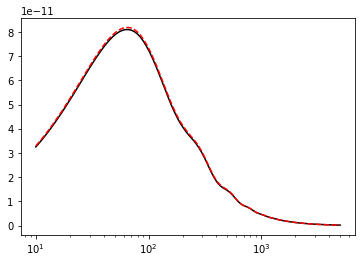

In [19]:
plt.plot(ells, IHiKappa, 'k')
plt.plot(ells, old_IHi_kappa[:,curr_bin], 'r--')

plt.xscale('log')